For the purpose of this experiment, I've put together a CSV dataset that consists of links to web articles and the labels that were assigned manually during data collection.
In this notebook we will explore the data and preprocess them further for the purpose of training the classifier.

## Imports

In [1]:
from IPython.display import display
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import transformers
from sklearn.model_selection import train_test_split

from utilities import utils

RANDOM_STATE = 5

## Data analysis

In [2]:
data_path = Path('../data/')

article_links = pd.read_csv(data_path/'article_links.csv')
utils.df_summarise(article_links)

(60, 2)

Index(['article_url', 'article_class'], dtype='object')

,article_url,article_class
0,https://www.spglobal.com/marketintelligence/en...,aml_cs
1,https://www.wsj.com/articles/natwest-pleads-gu...,aml_cs
2,https://www.bbc.com/news/business-59689581,aml_aac
3,https://www.fca.org.uk/news/press-releases/nat...,aml_aac
4,https://www.ft.com/content/7144ff53-5a17-477b-...,aml_cs


The dataset is only 60 observations - extremely low for a Deep Learning problem, and probably not enough for any meaningful algorithm to generalise over the total population. The below excercise is aimed more as an illustration of possible approach.

As mentioned, the links have been hand labelled. The intention of the model is to achieve the below goals:
1. allow to differentiate between articles related to money laundering activity and those that are not
1. for articles that are related to money laundering, we'd like to know if these pertain to one of the below:
    * allegations / accusations / charges
    * conviction / sentencing

Theoretically we could go for a two-step approach, i.e. estimate whether the article is AML related or not and only then ascertain if it pertains to allegations or convictions. However for the purpose of this excercise, we will attempt to estimate these two problems in one go. The argument here is that with enough data (and as we've seen in the proof of concept it means thousands of data points rather than millions) we could teach a neural network to distinguish the nuances between AML news variations.

Let's review the class distribution:

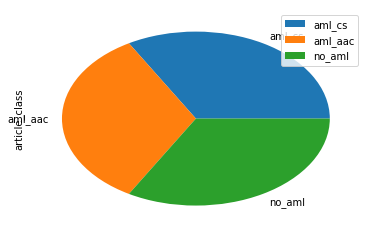

In [3]:
article_links.article_class.value_counts().plot.pie(legend=True)
plt.show()

All classes are equally represented in the current dataset. We will now proceed to extract the contents of the webpages using a custom built function. The logic behind this is this approach could be expanded to collect massive datasets through web scraping for given browser search results that would then only require undemanding manual reviews to check the scraping accuracy.

Let's extract the data now:

In [4]:
articles = article_links.copy()
articles['contents'] = articles['article_url'].apply(lambda url: utils.get_webpage_body(url))
utils.df_summarise(articles)

(60, 3)

Index(['article_url', 'article_class', 'contents'], dtype='object')

,article_url,article_class,contents
0,https://www.spglobal.com/marketintelligence/en...,aml_cs,\n \n\n \n latest-news-headlines\n ...
1,https://www.wsj.com/articles/natwest-pleads-gu...,aml_cs,\n\n\n\n\nSkip to Main ContentSkip to Search\n...
2,https://www.bbc.com/news/business-59689581,aml_aac,BBC HomepageSkip to contentAccessibility HelpY...
3,https://www.fca.org.uk/news/press-releases/nat...,aml_aac,\n\nSkip to main content\nSkip to search box\n...
4,https://www.ft.com/content/7144ff53-5a17-477b-...,aml_cs,Accessibility helpSkip to navigationSkip to co...


Let's look at some example contents:

In [5]:
idx = 58
for column in ['article_class', 'contents']:
    display(articles[column].iloc[idx])

'aml_cs'

'\n\n \n\nSkip to content\n\n\n\n\n\t\t\tContinuing Coverage\t\t\n\n\n\t\t\t\tSecond man arrested on gun charges connected to the Sacramento mass shooting, police say. Tap/click for details.\t\t\t\n\n\n\n\n\n\n \n\n\n\n\nMain Navigation\n\n\n\n\nSearch\n\n\n\n\nSearch for:\n\n\n\n\n\n\n\n\n\nLocal\nWeather\nInvestigations\nVideo\nOlympics\nEntertainment\nSports\nNewsletters\n \n\n\n\nLive TV\n\n\nShare\nClose\n\n\n \n \n\n\n\nTrending\n\nForecast: Warmer Temps Incoming\nSacramento Mass Shooting\nMother\'s Warning After Tragedy\nCheapest Gas in Bay Area\nSaving SF\nLive Updates: Russia-Ukraine Crisis\n\n\nExpand\n\n\n\n\n\n \n \n\n\n\n\n\n\n\n\n\n\n\n\ncrime \n\n\n\n\t\tRetired SJ Cop Sentenced for Millions in Insurance Fraud, Money Laundering\t\n\n\n\t\t\t\t\tBy Bay City News •\n\nPublished March 29, 2022 •\nUpdated on March 29, 2022 at 9:37 pm \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nA retired San Jose Police officer was sentenced to three years in jail on Tuesday for using a

The extraction process could potentially be improved further given time. As we will see in a moment however, a lot of the problems with the contents will be removed in the tokenisation process.

For tokenisation, we will use the dedicated pretrained English tokeniser for the BERT model: 

In [6]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

tokens = tokenizer(articles['contents'].iloc[idx])
tokenizer.decode(tokens['input_ids'])

Token indices sequence length is longer than the specified maximum sequence length for this model (947 > 512). Running this sequence through the model will result in indexing errors


'[CLS] Skip to content Continuing Coverage Second man arrested on gun charges connected to the Sacramento mass shooting, police say. Tap / click for details. Main Navigation Search Search for : Local Weather Investigations Video Olympics Entertainment Sports Newsletters Live TV Share Close Trending Forecast : Warmer Temps Incoming Sacramento Mass Shooting Mother\'s Warning After Tragedy Cheapest Gas in Bay Area Saving SF Live Updates : Russia - Ukraine Crisis Expand crime Retired SJ Cop Sentenced for Millions in Insurance Fraud, Money Laundering By Bay City News • Published March 29, 2022 • Updated on March 29, 2022 at 9 : 37 pm A retired San Jose Police officer was sentenced to three years in jail on Tuesday for using a side security business to commit millions of dollars in insurance fraud, money laundering, tax evasion and worker exploitation, the Santa Clara District Attorney\'s Office said. Robert Foster, 48, of Morgan Hill, was convicted of several felonies, including 173 acts of

The unnecessary non-alphanumeric characters have been removed. There are still some leftovers at the start and end of the contents coming from the page header and footer. This shows why using a naive approach like head / tail only would probably fail - the contents we're after are actually in the middle part of the article.

At this point we could decide to use a simpler algorithm that would be based on the popular bag-of-words approach, i.e. classifying articles based on keyword frequency. The downside of such an approach however is loosing contextual information stored within the sequences themselves. This is important as among the non-AML related examples you will find articles e.g. about financial penalties of other kinds or Acute Myeloid Leukemia (AML for short) treatment. For such articles, sequence context becomes important. Therefore, Transformer based approach is still our choice for the matter for now - although given more time it would be interesting to compare the model performance to a bag-of-words baseline.

As in the proof-of-concept, we'll measure article length in terms of tokens:

In [7]:
check_num_of_tokens = lambda row: len(tokenizer(row)['input_ids'])

articles['num_of_tokens'] = articles['contents'].apply(check_num_of_tokens)
utils.df_summarise(articles)

(60, 4)

Index(['article_url', 'article_class', 'contents', 'num_of_tokens'], dtype='object')

,article_url,article_class,contents,num_of_tokens
0,https://www.spglobal.com/marketintelligence/en...,aml_cs,\n \n\n \n latest-news-headlines\n ...,2063
1,https://www.wsj.com/articles/natwest-pleads-gu...,aml_cs,\n\n\n\n\nSkip to Main ContentSkip to Search\n...,3840
2,https://www.bbc.com/news/business-59689581,aml_aac,BBC HomepageSkip to contentAccessibility HelpY...,1427
3,https://www.fca.org.uk/news/press-releases/nat...,aml_aac,\n\nSkip to main content\nSkip to search box\n...,2119
4,https://www.ft.com/content/7144ff53-5a17-477b-...,aml_cs,Accessibility helpSkip to navigationSkip to co...,2255


And the article length distribution:

count      60.000000
mean     2180.783333
std      1036.875033
min       156.000000
25%      1555.000000
50%      1868.000000
75%      2527.250000
max      5455.000000
Name: num_of_tokens, dtype: float64

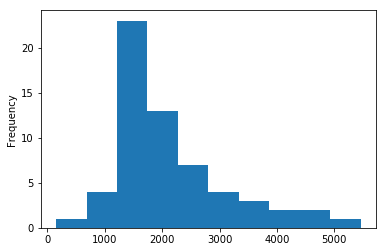

In [8]:
articles['num_of_tokens'].plot.hist()
articles['num_of_tokens'].describe()

The articles in our AML dataset are considerably longer then the ones in the BBC dataset - proving our approach should be robust to variable article length, as we expect RoBERT to be.

## Dataset generation

Again, we will hold out 20% of the dataset. Here, this will mean our validation set will only have 12 examples. We will preserve the class distributions using the `stratify` argument to ensure we have a balanced view on the model performance:

In [9]:
train, val = train_test_split(
    articles, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    shuffle=True, 
    stratify=articles['article_class']
    )
for dataset in [train, val]:
    print('='*60)
    print(dataset.shape)
    print(dataset['article_class'].value_counts())


(48, 4)
aml_aac    16
no_aml     16
aml_cs     16
Name: article_class, dtype: int64
(12, 4)
no_aml     4
aml_aac    4
aml_cs     4
Name: article_class, dtype: int64


In [10]:
train.to_csv(data_path/'aml_train.csv')
val.to_csv(data_path/'aml_val.csv')

## Model training

Training related imports:

In [11]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

from dataset.long_text_data_module import LongTextDataModule
from model.long_text_classifier import LongTextClassifier
from model.callbacks import SwitchPretrainedWeightsState

Detailed configuration can be found in the `aml_config.yaml` file.

Because our dataset is so small, we will artificially increase the training set using an upsampling scheme - it will be increased by a factor of 10 to allow model convergence:

In [12]:
NUM_EPOCHS = 20
SEQUENCE_LENGTH = 200
SEQUENCE_OVERLAP = 50
BATCH_SIZE = 1  # TODO: at the moment model can only handle online learning
NUM_FREEZE_PRETRAINED = 0
CONFIG_PATH = 'settings/aml_config.yaml'


data_module = LongTextDataModule(
    config_path=CONFIG_PATH,
    sequence_length=SEQUENCE_LENGTH,
    overlap=SEQUENCE_OVERLAP
)

model = LongTextClassifier(
    num_classes=data_module.num_classes,
    config_path=CONFIG_PATH,
    num_epochs_freeze_pretrained=NUM_FREEZE_PRETRAINED,
    )

callbacks = [
    SwitchPretrainedWeightsState(),
    ModelCheckpoint(
        filename=f'AMLClassifier-seq_len{SEQUENCE_LENGTH}-ovlp{SEQUENCE_OVERLAP}'+'-{epoch}-{val/accuracy:.3f}',
        monitor='val/accuracy',
        mode='max',
        save_top_k=1,
        verbose=True,
    ),
    EarlyStopping(
        monitor='val/accuracy',
        mode='max',
        patience=10,
        verbose=True,
        ),
]

trainer = Trainer(
    max_epochs=NUM_EPOCHS,
    fast_dev_run=False,
    default_root_dir='../output',
    callbacks=callbacks,
    gpus=1,
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [13]:
trainer.fit(
    model,
    data_module.train_dataloader(),
    data_module.val_dataloader(),
)

Upsampled 480 samples
Tokenisation of content strips:


  0%|          | 0/528 [00:00<?, ?it/s]

Loaded dataset aml_train
Number of tokens: 528
Number of classes: 3
Tokenisation of content strips:


  0%|          | 0/12 [00:00<?, ?it/s]

Loaded dataset aml_val
Number of tokens: 12
Number of classes: 3


/home/tkaleczy/git/AML_news_detection/environment/aml_venv/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name                | Type       | Params
---------------------------------------------------
0 | feature_extractor   | BertModel  | 108 M 
1 | aggregating_network | LSTM       | 348 K 
2 | predictor           | Sequential | 3.1 K 
3 | accuracy            | Accuracy   | 0     
---------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
434.646   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

val/accuracy 0.5


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 527: val/accuracy reached 0.25000 (best 0.25000), saving model to "../output/lightning_logs/version_2/checkpoints/AMLClassifier-seq_len200-ovlp50-epoch=0-val/accuracy=0.250.ckpt" as top 1


val/accuracy 0.25


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 1055: val/accuracy reached 0.41667 (best 0.41667), saving model to "../output/lightning_logs/version_2/checkpoints/AMLClassifier-seq_len200-ovlp50-epoch=1-val/accuracy=0.417.ckpt" as top 1


val/accuracy 0.4166666567325592


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 1583: val/accuracy reached 0.58333 (best 0.58333), saving model to "../output/lightning_logs/version_2/checkpoints/AMLClassifier-seq_len200-ovlp50-epoch=2-val/accuracy=0.583.ckpt" as top 1


val/accuracy 0.5833333134651184


Validating: 0it [00:00, ?it/s]

Epoch 3, step 2111: val/accuracy was not in top 1


val/accuracy 0.5


Validating: 0it [00:00, ?it/s]

Epoch 4, step 2639: val/accuracy was not in top 1


val/accuracy 0.5


Validating: 0it [00:00, ?it/s]

Epoch 5, step 3167: val/accuracy was not in top 1


val/accuracy 0.5


Validating: 0it [00:00, ?it/s]

Epoch 6, step 3695: val/accuracy was not in top 1


val/accuracy 0.5


Validating: 0it [00:00, ?it/s]

Epoch 7, step 4223: val/accuracy was not in top 1


val/accuracy 0.5


Validating: 0it [00:00, ?it/s]

Epoch 8, step 4751: val/accuracy was not in top 1


val/accuracy 0.5


Validating: 0it [00:00, ?it/s]

Epoch 9, step 5279: val/accuracy was not in top 1


val/accuracy 0.5


Validating: 0it [00:00, ?it/s]

Epoch 10, step 5807: val/accuracy was not in top 1


val/accuracy 0.5


Validating: 0it [00:00, ?it/s]

Epoch 11, step 6335: val/accuracy was not in top 1


val/accuracy 0.5


Validating: 0it [00:00, ?it/s]

Epoch 12, step 6863: val/accuracy was not in top 1


val/accuracy 0.5


1

## Conclusions

The training results of both the BBC (orange) and AML (red) models can be seen on the below snippet from Tensorboard:

<img src='../data/tensorboard_results.PNG' width="650"></img>

The conclusions:
* as expected, `batch_size=1` leads to volatilty in training - as seen in the loss graph
* the BBC model managed to learn to effectively differentiate the classes, with loss coming down on both the training and validation sets
* by comparison, the AML model displays significant signs of overfitting to results (with training loss converging and validation loss diverging) and a general poor quality of training (val loss above 1) - a likely result of massive upsampling and not enough data for effective training (or validation for that matter..)

Possible further improvements for the AML model - apart from those mentioned in the PoC - include:
* obviously - increasing and further diversifying the training and validation datasets
* using data augmentation in combination with upsampling